In [1019]:
%matplotlib inline

In [1020]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Ferdinand HW4

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250 $\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda_{CDM}$ cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [1021]:
#!wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat

In [1022]:

data = at.Table.read('aless_average_seds.dat', format='ascii', names=['wave','fnu', 'fnu_bright', 'fnu_faint'], data_start=1)
# Extract data
wavelength_rest = data['wave'] * u.micron 
flux_nu_rest = data['fnu'] * u.mJy       
fnu_rest_bright = data['fnu_bright'] * u.mJy  
fnu_rest_faint = data['fnu_faint'] * u.mJy 
print(data)

def wave_micron_to_nu(wavelength):
    return (ap.constants.c / (wavelength).to(u.m)).to(u.Hz)

nu_rest = wave_micron_to_nu(wavelength_rest) # Convert rest wave to rest freq

    wave       fnu   fnu_bright fnu_faint
------------ ------- ---------- ---------
      0.0094     0.0        0.0       0.0
      0.0096     0.0        0.0       0.0
      0.0098     0.0        0.0       0.0
        0.01     0.0        0.0       0.0
     0.01019     0.0        0.0       0.0
      0.0104     0.0        0.0       0.0
      0.0106     0.0        0.0       0.0
     0.01079     0.0        0.0       0.0
     0.01099     0.0        0.0       0.0
     0.01141     0.0        0.0       0.0
         ...     ...        ...       ...
207081.01562 0.08567    0.09518   0.02606
210445.82812 0.08667    0.09629   0.02637
213865.26562 0.08769    0.09742   0.02668
217340.28125 0.08874    0.09859     0.027
220871.78125 0.08978    0.09974   0.02731
224460.60938 0.09085    0.10093   0.02765
 228107.8125 0.09192    0.10212   0.02797
   231814.25 0.09301    0.10333   0.02831
235580.90625 0.09414    0.10459   0.02864
239408.76562 0.09525    0.10582   0.02897
243298.84375 0.09637    0.10707   

In [1023]:
"""
# Fig 1. - OLD CODE
z_grid = np.arange(1, 8.25, 0.25)
bands = [24, 70, 110, 160, 200, 350, 450, 500, 850, 1100, 1400, 2100] * u.micron # List of band wavelength in micron
bandwidth = 3 * u.micron

# For each band, calculate the observed wavelength bands limits
band_limits = {}
for band in bands:
    lambda_obs_min = band - bandwidth / 2
    lambda_obs_max = band + bandwidth / 2
    band_limits[band] = [lambda_obs_min, lambda_obs_max]

L_Sun = (382.8e24 * u.J / u.s).to(u.erg / u.s) # Acquired from https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
# Assuming the total bolometric luminosity is equivalent to the total IR Luminosity because the flux dominates in IR, the other regions can be neglected
Lum = 3.5e12 * L_Sun # from da Cunha (2015) https://arxiv.org/pdf/1504.04376 where the data is from

whole_fnu_integration = np.abs(np.trapz(flux_nu_rest, nu_rest)) #.to(u.erg / u.s / u.cm / u.cm)

# Calculating Snu, Snu = (1+z)/(4 pi DL^2) L f(nu_obs(1+z))/(whole_fnu_integration)
# We use fnu_faint and fnu_bright for uncertainties in the plot
def Snu(z, wave_obs):
    # Estimating Luminosity distance
    D_L = cosmo.luminosity_distance(z).to(u.cm) 
    
    # Since in the eqn, it is f(nu(1+z)) it means that it is equivalent to fnu (lambda_rest)
    # Calculate the rest wavelength based on the observed wavelength
    lambda_obs_min, lambda_obs_max = band_limits[wave_obs]
    lambda_rest_min = lambda_obs_min / (1 + z)
    lambda_rest_max = lambda_obs_max / (1 + z)
    
    # The range of rest lambda to integrate over bandwidth
    lambda_rest_range = np.linspace(lambda_rest_min.value, lambda_rest_max.value, 1000) * u.micron
    
    # Make interpolation function of fnu, fnu_bright, fnu_faint
    fnu_rest_interp = np.interp(lambda_rest_range, wavelength_rest, flux_nu_rest)
    fnu_rest_bright_interp = np.interp(lambda_rest_range, wavelength_rest, fnu_rest_bright)
    fnu_rest_faint_interp = np.interp(lambda_rest_range, wavelength_rest, fnu_rest_faint)
    
    # Integrate over bandwidth
    integral = np.trapz(fnu_rest_interp, lambda_rest_range)
    integral_faint = np.trapz(fnu_rest_faint_interp, lambda_rest_range)
    integral_bright = np.trapz(fnu_rest_bright_interp, lambda_rest_range)
    
    # Average rest flux density over bandwidth
    fnu_rest_avg = integral / (lambda_rest_max - lambda_rest_min) 
    fnu_rest_bright_avg = integral_bright / (lambda_rest_max - lambda_rest_min)
    fnu_rest_faint_avg = integral_faint / (lambda_rest_max - lambda_rest_min)
    
    # Calculating Snu
    Snu = (((1+z)*Lum)/(4*np.pi*D_L**2) * (fnu_rest_avg)/(whole_fnu_integration)).to(u.mJy)
    Snu_faint = (((1+z)*Lum)/(4*np.pi*D_L**2) * (fnu_rest_faint_avg)/(whole_fnu_integration)).to(u.mJy)
    Snu_bright = (((1+z)*Lum)/(4*np.pi*D_L**2) * (fnu_rest_bright_avg)/(whole_fnu_integration)).to(u.mJy)
    return Snu, Snu_faint, Snu_bright

Snu_list = {band: [] for band in band_limits}
Snu_faint_list = {band: [] for band in band_limits}
Snu_bright_list = {band: [] for band in band_limits}
for z in z_grid:
    for band in band_limits:
        Snu_value, Snu_faint, Snu_bright = Snu(z, band)
        Snu_list[band].append(Snu_value)
        Snu_faint_list[band].append(Snu_faint)
        Snu_bright_list[band].append(Snu_bright)
 
# Plot without the uncertainty of fnu_faint and fnu_bright        
plt.figure(figsize=(10, 7.5))
for band in band_limits:
    Snu = []
    for f in Snu_list[band]:
        Snu.append(f.value)
    plt.plot(z_grid, Snu, label=f"{band.value} $\mu$ m")

plt.xlabel('Redshift (z)')
plt.ylabel('Observed Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
         ncol=1, fancybox=True, shadow=True)
plt.title('Observed Flux Density vs Redshift for different bands')
plt.show() 

# Plot with the uncertainty of fnu_faint and fnu_bright
plt.figure(figsize=(10, 7.5))
for band in band_limits:
    Snu = []
    Snu_faint = []
    Snu_bright = []
    for f, f_faint, f_bright in zip(Snu_list[band], Snu_faint_list[band], Snu_bright_list[band]):
        Snu.append(f.value)
        Snu_faint.append(f_faint.value)
        Snu_bright.append(f_bright.value)
    plt.plot(z_grid, Snu, label=f"{band.value} $\mu$ m")
    # Plot uncertainty
    plt.fill_between(z_grid, Snu_faint, Snu_bright, alpha=0.2)

plt.xlabel('Redshift (z)')
plt.ylabel('Observed Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
         ncol=1, fancybox=True, shadow=True)
plt.title('Observed Flux Density vs Redshift for different bands (with uncertainty)')
plt.show() 
"""

'\n# Fig 1. - OLD CODE\nz_grid = np.arange(1, 8.25, 0.25)\nbands = [24, 70, 110, 160, 200, 350, 450, 500, 850, 1100, 1400, 2100] * u.micron # List of band wavelength in micron\nbandwidth = 3 * u.micron\n\n# For each band, calculate the observed wavelength bands limits\nband_limits = {}\nfor band in bands:\n    lambda_obs_min = band - bandwidth / 2\n    lambda_obs_max = band + bandwidth / 2\n    band_limits[band] = [lambda_obs_min, lambda_obs_max]\n\nL_Sun = (382.8e24 * u.J / u.s).to(u.erg / u.s) # Acquired from https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html\n# Assuming the total bolometric luminosity is equivalent to the total IR Luminosity because the flux dominates in IR, the other regions can be neglected\nLum = 3.5e12 * L_Sun # from da Cunha (2015) https://arxiv.org/pdf/1504.04376 where the data is from\n\nwhole_fnu_integration = np.abs(np.trapz(flux_nu_rest, nu_rest)) #.to(u.erg / u.s / u.cm / u.cm)\n\n# Calculating Snu, Snu = (1+z)/(4 pi DL^2) L f(nu_obs(1+z))/(whol

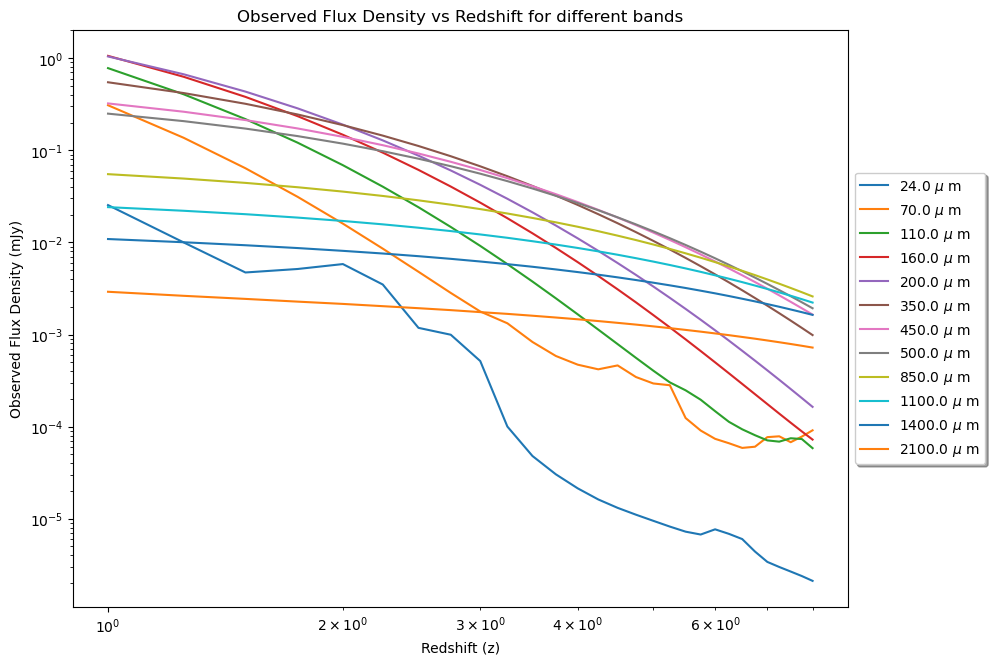

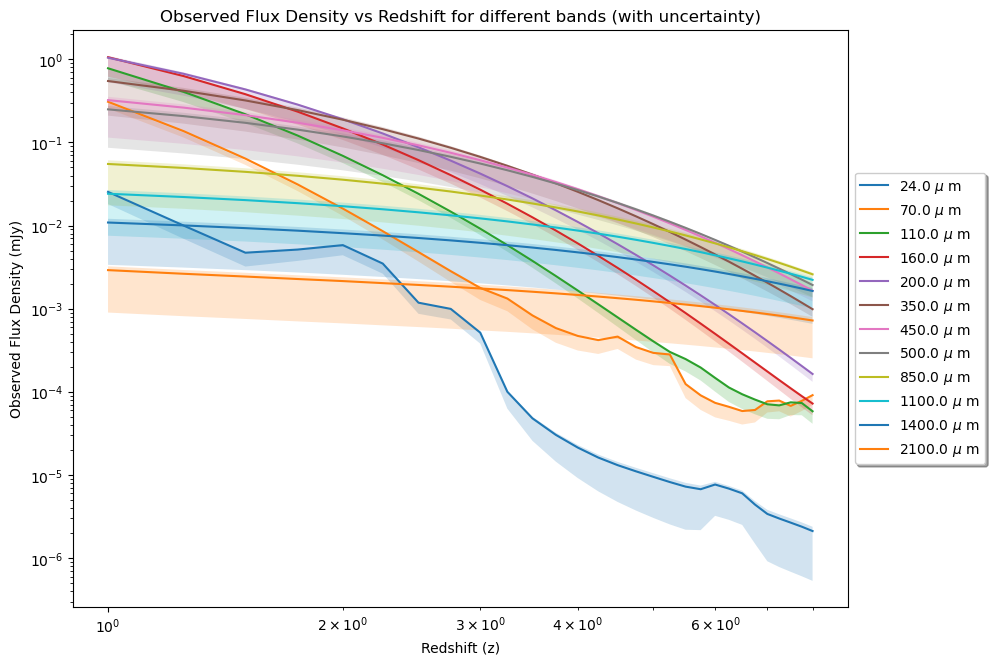

In [1024]:
z_grid = np.arange(1, 8.25, 0.25)
bands = [24, 70, 110, 160, 200, 350, 450, 500, 850, 1100, 1400, 2100] * u.micron # List of band wavelength in micron
bandwidth = 3 * u.micron

# For each band, calculate the observed wavelength bands limits
band_limits = {}
for band in bands:
    lambda_obs_min = band - bandwidth / 2
    lambda_obs_max = band + bandwidth / 2
    band_limits[band] = [lambda_obs_min, lambda_obs_max]
    
def Snu(z, fnu):
    # Deriving from Fobs = Femit/(1+z) while DL = D^2 (1+z)^2 so later if we substitute to the reference equation
    # Snu ~ fnu (1+z)/(1+z) / (1+z)^4 ~ fnu (1+z)^(-4)
    return fnu/(1+z)**4

Snu_list = {band: [] for band in band_limits}
Snu_faint_list = {band: [] for band in band_limits}
Snu_bright_list = {band: [] for band in band_limits}
for z in z_grid:
    for band in band_limits:
        # Calculate the rest wavelength based on the observed wavelength
        lambda_obs_min, lambda_obs_max = band_limits[band]
        lambda_rest_min = lambda_obs_min / (1 + z)
        lambda_rest_max = lambda_obs_max / (1 + z)
        
        # The range of rest lambda to integrate over bandwidth
        lambda_rest_range = np.linspace(lambda_rest_min.value, lambda_rest_max.value, 1000) * u.micron
        
        # Make interpolation function of fnu, fnu_bright, fnu_faint
        fnu_rest_interp = np.interp(lambda_rest_range, wavelength_rest, flux_nu_rest)
        fnu_rest_bright_interp = np.interp(lambda_rest_range, wavelength_rest, fnu_rest_bright)
        fnu_rest_faint_interp = np.interp(lambda_rest_range, wavelength_rest, fnu_rest_faint)
        
        # Integrate over bandwidth
        integral = np.trapz(fnu_rest_interp, lambda_rest_range)
        integral_faint = np.trapz(fnu_rest_faint_interp, lambda_rest_range)
        integral_bright = np.trapz(fnu_rest_bright_interp, lambda_rest_range)
        
        # Average rest flux density over bandwidth
        fnu_rest_avg = integral / (lambda_rest_max - lambda_rest_min) 
        fnu_rest_bright_avg = integral_bright / (lambda_rest_max - lambda_rest_min)
        fnu_rest_faint_avg = integral_faint / (lambda_rest_max - lambda_rest_min)
        
        # Calculating Snu
        Snu_flux = Snu(z, fnu_rest_avg)
        Snu_bright = Snu(z, fnu_rest_bright_avg)
        Snu_faint = Snu(z, fnu_rest_faint_avg)
        Snu_list[band].append(Snu_flux)
        Snu_faint_list[band].append(Snu_faint)
        Snu_bright_list[band].append(Snu_bright)

# Plot without the uncertainty of fnu_faint and fnu_bright        
plt.figure(figsize=(10, 7.5))
for index, band in enumerate(band_limits):
    Snu = []
    for f in Snu_list[band]:
        Snu.append(f.value)
    plt.plot(z_grid, Snu, label=f"{band.value} $\mu$ m")

plt.xlabel('Redshift (z)')
plt.ylabel('Observed Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
         ncol=1, fancybox=True, shadow=True)
plt.title('Observed Flux Density vs Redshift for different bands')
plt.show() 

# Plot with the uncertainty of fnu_faint and fnu_bright
plt.figure(figsize=(10, 7.5))
for index, band in enumerate(band_limits):
    Snu = []
    Snu_faint = []
    Snu_bright = []
    for f, f_faint, f_bright in zip(Snu_list[band], Snu_faint_list[band], Snu_bright_list[band]):
        Snu.append(f.value)
        Snu_faint.append(f_faint.value)
        Snu_bright.append(f_bright.value)
    plt.plot(z_grid, Snu, label=f"{band.value} $\mu$ m")
    # Plot uncertainty
    plt.fill_between(z_grid, Snu_faint, Snu_bright, alpha=0.2)

plt.xlabel('Redshift (z)')
plt.ylabel('Observed Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
         ncol=1, fancybox=True, shadow=True)
plt.title('Observed Flux Density vs Redshift for different bands (with uncertainty)')
plt.show() 

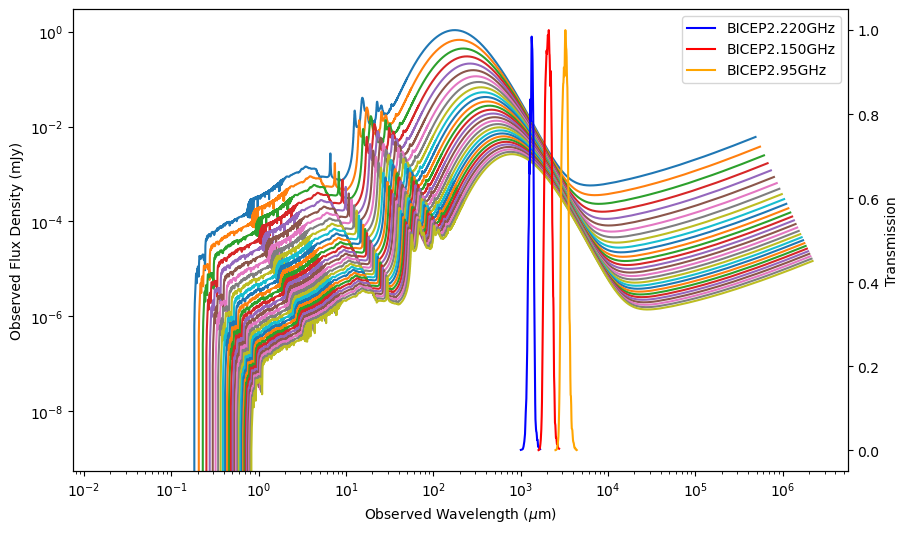

In [1025]:
# Fig 2.
from specreduce.calibration_data import AtmosphericTransmission
# Getting BICEP2 data
ext_220GHz = AtmosphericTransmission(data_file='./data/BICEP_BICEP2.220GHz.dat')
ext_150GHz = AtmosphericTransmission(data_file='./data/BICEP_BICEP2.150GHz.dat')
ext_95GHz = AtmosphericTransmission(data_file='./data/BICEP_BICEP2.95GHz.dat')
# Redshift grid
z_grid = np.arange(1, 8.25, 0.25)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for z in z_grid:
    flux_z = flux_nu_rest/(1+z)**4 # SED_nu at z = SED_intrinsic_nu * (1+z)
    observed_wave = wavelength_rest*(1+z)
    ax1.plot(observed_wave, flux_z)

ax2.plot(ext_220GHz.spectral_axis/10000, ext_220GHz.transmission, label="BICEP2.220GHz", color="blue")
ax2.plot(ext_150GHz.spectral_axis/10000, ext_150GHz.transmission, label="BICEP2.150GHz", color="red")
ax2.plot(ext_95GHz.spectral_axis/10000, ext_95GHz.transmission, label="BICEP2.95GHz", color="orange")

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"Observed Wavelength ($\mu$m)")
ax1.set_ylabel("Observed Flux Density (mJy)")
ax2.set_ylabel("Transmission")
plt.legend()
plt.show()

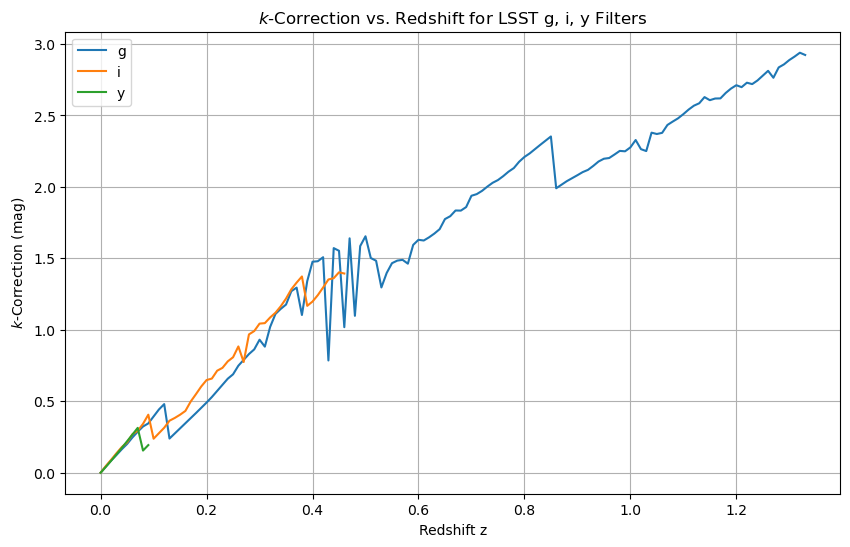

In [1026]:
# Fig 3.

# Let's convert fnu to flambda, flambda = fnu c/lambda^2 (our flambda is in erg/s/cm2/Angstrom)
wavelength_rest_AA = wavelength_rest.to(u.Angstrom)
flux_lambda_rest = (flux_nu_rest.to(u.erg / u.s / u.cm**2 / u.Hz) * ap.constants.c / (wavelength_rest_AA**2)).to(u.erg / u.s / u.cm**2 / u.Angstrom)

# Func for loading filters
def load_filter(filter):
    data = AtmosphericTransmission(filter)
    wavelength = data.spectral_axis * u.Angstrom / u.um
    transmission = data.transmission
    return wavelength, transmission

# Load filters
wave_eff_filters = {'u': 3641.17, 'g': 4704.08, 'r': 6155.82, 'i': 7504.64, 'z': 8695.51, 'y': 10056.62}
filters = {'u': {}, 'g': {}, 'r': {}, 'i': {}, 'z': {}, 'y': {}}
observed_filters = ['g', 'i', 'y']
for filter in filters:
    wavelength, transmission = load_filter(f'./data/LSST_LSST.{filter}_filter.dat')
    filters[filter] = {'wave_eff': wave_eff_filters[filter] * u.Angstrom, 'wavelength': wavelength, 'transmission': transmission}

# Initialize some things...
z_array = np.arange(0, 2.01, 0.01)
k_corrections = {filter: [] for filter in observed_filters}
z_valid = {filter: [] for filter in observed_filters}

# Let's try to compute the k-corrections
for filter in observed_filters:
    # Observed data
    lambda_obs_eff = filters[filter]['wave_eff'] # in Angstrom
    lambda_obs = filters[filter]['wavelength'] # in Angstrom
    R_lambda_obs = filters[filter]['transmission']
        
    for z in z_array:
        lambda_rest = lambda_obs/(1+z) # in Angstrom
        lambda_rest_eff = lambda_obs_eff/(1+z) # in Angstrom
        
        # If it's not inside the UGRIZY band, we can just continue
        if lambda_obs_eff.value < min(filters['u']['wavelength'].value)/(1+z) or lambda_obs_eff.value > max(filters['y']['wavelength'].value)/(1+z):
            continue
        
        # Finding the rest frame transmission
        closest_filter = filter
        wavelength_diff = np.abs(lambda_rest_eff - filters[filter]['wave_eff'])
        for filter_name in filters:
            diff = abs(lambda_rest_eff - filters[filter_name]['wave_eff'])
            if diff < wavelength_diff:
                wavelength_diff = diff
                closest_filter = filter_name
                
        # Then we can find the transmission for rest wavelength!
        Q_lambda_rest = np.interp(lambda_rest, filters[closest_filter]['wavelength'], filters[closest_filter]['transmission'])
        
        # Find the function of f_lambda in both observed and rest
        f_lambda_obs = np.interp(lambda_obs, wavelength_rest_AA, flux_lambda_rest/(1+z)**4)
        f_lambda_rest = np.interp(lambda_rest, wavelength_rest_AA, flux_lambda_rest)
        
        # But our f_lambda_rest = f(lambda_rest * (1+z))
        f_lambda_rest_z = np.interp(lambda_rest*(1+z), lambda_rest, f_lambda_rest)
        
        # Calculate the observed and rest integrals
        rest = np.trapz(lambda_rest * f_lambda_rest_z * Q_lambda_rest, lambda_rest)
        observed = np.trapz(lambda_obs * f_lambda_obs * R_lambda_obs, lambda_obs)
        
        # Calculate the transmission from the AB synthetic source
        # Since gnu is the same for numerator (rest) and denominator (obs), g_lambda, R, and Q is different
        # g_lambda would just be gnu (lambda)^(-2), so the integral would be prop to lambda^(-1) R (or Q)
        
        rest_source = np.trapz(lambda_rest**(-1) * Q_lambda_rest, lambda_rest)
        observed_source = np.trapz(lambda_obs**(-1) * R_lambda_obs, lambda_obs)
        
        # Calculate the k-correction
        k_corr = -2.5 * np.log10((1/(1+z)) * ((observed * rest_source)/(rest*observed_source)))
        
        k_corrections[filter].append(k_corr)
        z_valid[filter].append(z)
    
# # Plotting     
plt.figure(figsize=(10, 6))
for filter in observed_filters:
    if len(z_valid[filter]) == 0:
        continue
    plt.plot(z_valid[filter], k_corrections[filter], label=filter)

plt.xlabel('Redshift z')
plt.ylabel('$k$-Correction (mag)')
plt.title('$k$-Correction vs. Redshift for LSST g, i, y Filters')
plt.legend()
plt.grid(True)
plt.show()

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

The mean of true distance is 1423.770877266871 Mpc
Average magnitude of original sample: 21.11
Average magnitude of detected sample: 18.86


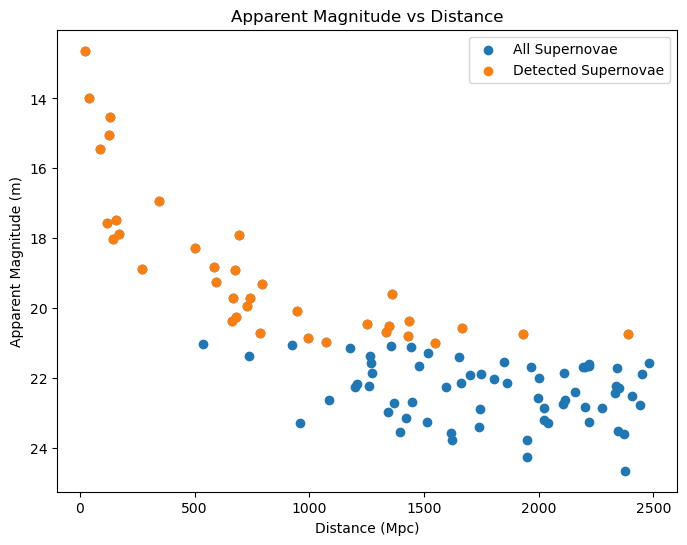

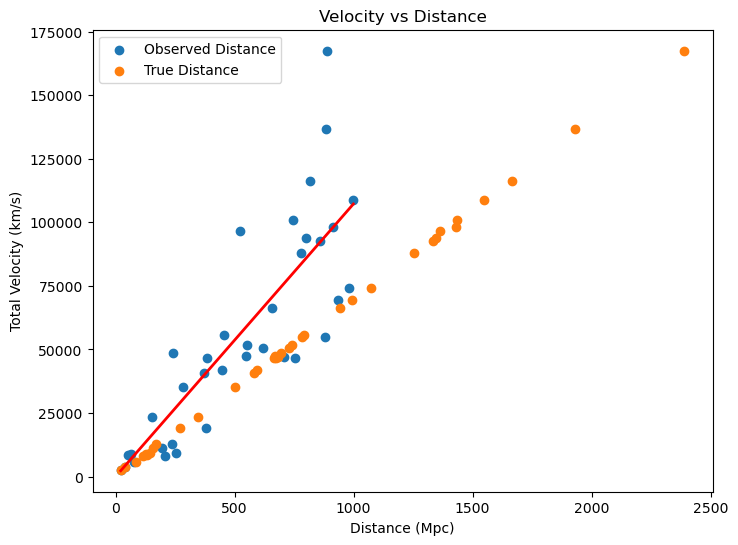

Estimated H_0: 107.32 ± 6.21 km/s/Mpc
Level bias is quite the same as the difference in the hubble constant: 37.32 km / (Mpc s) which is around 53.32% overestimation


In [1027]:

def calculate_H0(N=100):
    # Part 1.
    R_max = 2500
    true_distance = R_max * np.random.uniform(0, 1, N) # Random uniform true distances in a sphere in Mpc
    mean_true_distance = np.mean(true_distance) * u.Mpc # Mean distance
    print(f"The mean of true distance is {mean_true_distance}")

    # Part 2.
    M_mean = -19
    M_std = 1
    M = np.random.normal(M_mean, M_std, N)# Generating M
    m = M+5*np.log10(true_distance*10**6/10) # Calculating m

    # Avg magnitudes
    detected = m <= 21
    m_detected = m[detected]
    true_distance_detected = true_distance[detected]
    m_mean = np.mean(m)
    m_detected_mean = np.mean(m_detected)
    print(f"Average magnitude of original sample: {m_mean:.2f}")
    print(f"Average magnitude of detected sample: {m_detected_mean:.2f}")

    # Scatter plot for all supernovae
    plt.figure(figsize=(8,6))
    plt.scatter(true_distance, m, label='All Supernovae')
    plt.scatter(true_distance_detected, m_detected, label='Detected Supernovae')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Apparent Magnitude (m)')
    plt.title('Apparent Magnitude vs Distance')
    plt.legend()
    plt.gca().invert_yaxis()  # Magnitude scale is inverted
    plt.show()

    # Part 3.
    # Finding velocity
    v_recession = cosmo.H0 * true_distance * u.Mpc
    v_peculiar = np.random.normal(0, 600, N) * u.km / u.s
    v_total = v_recession + v_peculiar
    v_total_detected = v_total[detected]
    # Finding observed distance for the detected supernovae
    observed_distance = 10 ** ((m_detected - M_mean + 5) / 5) / 1e6 * u.Mpc

    # Scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(observed_distance, v_total_detected, label='Observed Distance')
    plt.scatter(true_distance_detected, v_total_detected, label='True Distance')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Total Velocity (km/s)')
    plt.legend()
    plt.title('Velocity vs Distance')

    # Part 4.
    # Let's do curve fitting
    # Our hubble law function
    def hubble_law(H0, d):
        return H0*d
    
    # Our velocity error
    sigma_v = np.full_like(v_total_detected, 600 * u.km / u.s) # km/s
    
    # Curve fitting
    popt, pcov = sp.optimize.curve_fit(hubble_law, observed_distance, v_total_detected, p0=[70], sigma=sigma_v)
    H0_est = popt[0]
    H0_est_error = np.sqrt(pcov[0][0])
    
    # Plot fitted line
    d_fit = np.linspace(min(observed_distance), max(observed_distance), 100)
    v_fit = hubble_law(d_fit, H0_est)
    plt.plot(d_fit, v_fit, 'r-', linewidth=2)
    # plt.plot(true_distance_detected, 70*true_distance_detected, 'b--')
    plt.show()
    
    print(f"Estimated H_0: {H0_est:.2f} ± {H0_est_error:.2f} km/s/Mpc")
    print(f"Level bias is quite the same as the difference in the hubble constant: {H0_est * u.km / u.s / u.Mpc - cosmo.H0:.2f} which is around {((H0_est * u.km / u.s / u.Mpc - cosmo.H0) / cosmo.H0)*100:.2f}% overestimation")
    
calculate_H0()

The mean of true distance is 1201.5919663871687 Mpc
Average magnitude of original sample: 20.64
Average magnitude of detected sample: 18.71


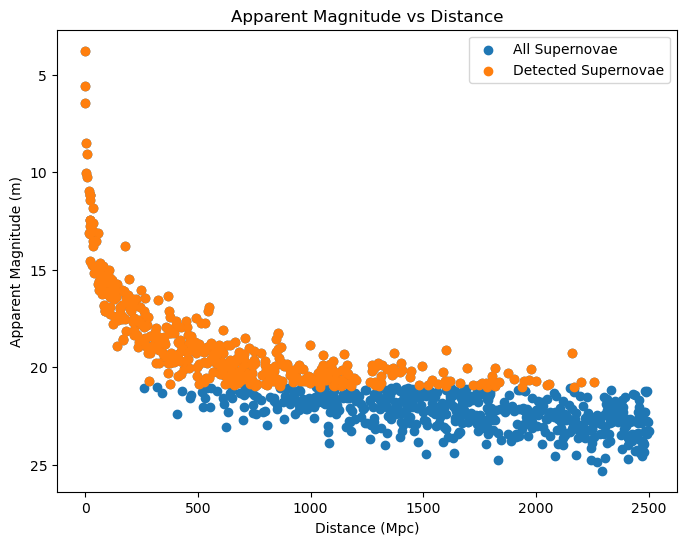

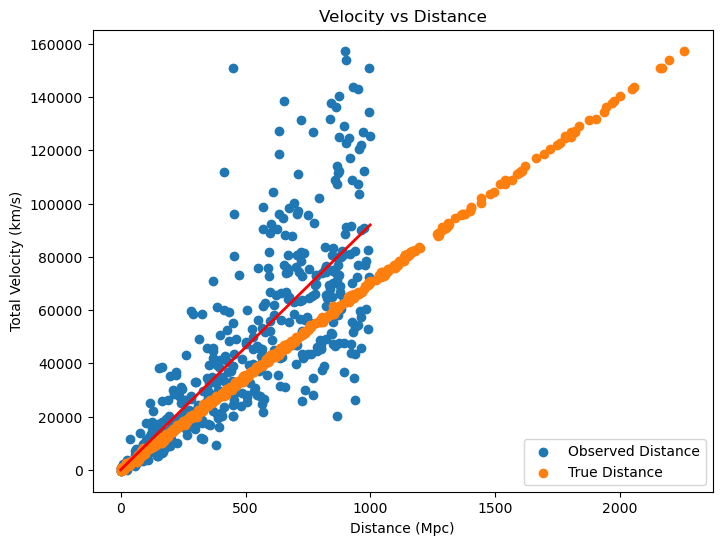

Estimated H_0: 92.08 ± 1.73 km/s/Mpc
Level bias is quite the same as the difference in the hubble constant: 22.08 km / (Mpc s) which is around 31.54% overestimation


In [1028]:
calculate_H0(N=1000)

The mean of true distance is 1251.8460733404204 Mpc
Average magnitude of original sample: 20.83
Average magnitude of detected sample: 18.84


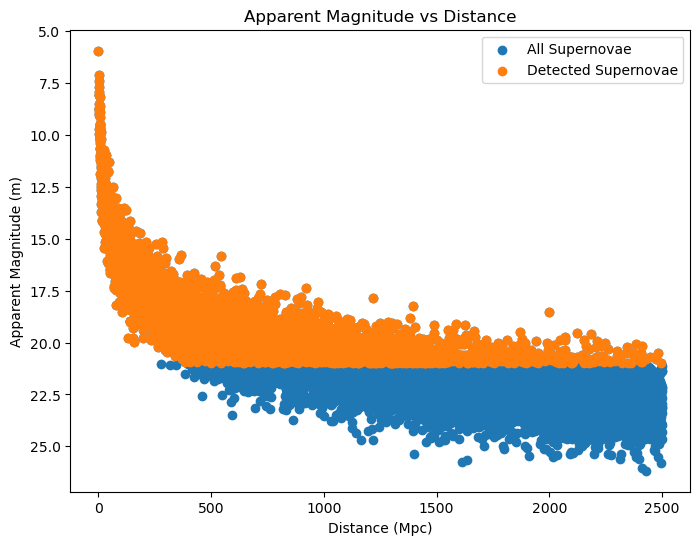

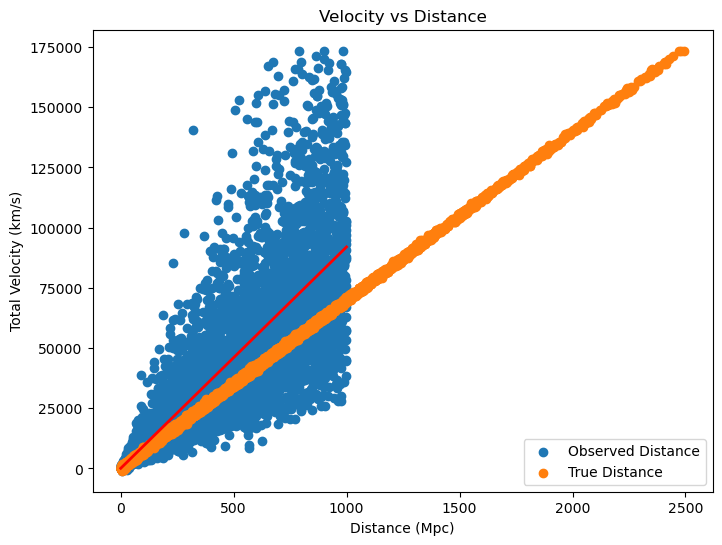

Estimated H_0: 91.97 ± 0.59 km/s/Mpc
Level bias is quite the same as the difference in the hubble constant: 21.97 km / (Mpc s) which is around 31.39% overestimation


In [1029]:
calculate_H0(N=10000)

## Answers to part 3 & 4:
1. [Part 3 - Effect of observing limit] The observing limit of $m_{max} = 21$ biases our sample to only closer (only around 1000 Mpc max) or brighter supernova. This makes our resulting samples do not represent the population (because those who have $m > 21$ won't be detected), leading to a misleading correlation between velocity and distance and also the overestimation/underestimation of $H_0$.
2. [Part 4 - Level of bias] The level of bias is quite a lot as it can reaches more than 135% of the original, regardless, this is due to our resulting samples from observation limit. As the number of samples increases, we can see the observing limit more apparent. We have the bias for $H_0$ fit is around $90$-ish $km/s/Mpc$
3. [Part 4 - Peculiar velocity impact] The peculiar velocity adds a more "scattered" velocity. At small distances, as the value of the recession velocity is around or smaller than the peculiar velocity, it will greatly impact the plot and increase uncertainty of the samples and the hubble constant. At large distances, however, as the value of the recession velocity is way way bigger than the peculiar velocity, it will not have that much impact (e.g., 120,000 km/s is around the same as 120,600 km/s.)
4. [Part 4 - Accounting for biases] To account the peculiar velocity and malmquist bias, we will need more samples from distributions on a bigger sphere as larger distances aren't affected by the peculiar velocity. We will also need to have a better observing limit as adding more samples with the same observing limit will not affect the results due to the samples have the same bias as the previous ones.

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!